In [ ]:
!pip install -q efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00


In [ ]:
# importing necesarry libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Lung Disease Dataset'
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"
test_dir = f"{data_dir}/test"
IMAGE_SIZE = (240, 240)
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 5

In [ ]:

# Data Augmentation
from tensorflow.keras.applications.efficientnet import preprocess_input
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


In [ ]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return float(lr * tf.math.exp(-0.1))
lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
# Build Model
input_tensor = Input(shape=(240, 240, 3))
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output_tensor)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train with timer
start_time = time.time()
history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=[lr_scheduler, early_stopping])
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5053s 26s/step - accuracy: 0.7380 - loss: 0.6870 - val_accuracy: 0.7937 - val_loss: 0.5045 - learning_rate: 0.0010
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 151s 796ms/step - accuracy: 0.8351 - loss: 0.4117 - val_accuracy: 0.8309 - val_loss: 0.5793 - learning_rate: 0.0010
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 143s 753ms/step - accuracy: 0.8665 - loss: 0.3605 - val_accuracy: 0.7902 - val_loss: 0.5966 - learning_rate: 0.0010
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 145s 764ms/step - accuracy: 0.8811 - loss: 0.3131 - val_accuracy: 0.6746 - val_loss: 1.3215 - learning_rate: 0.0010
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 145s 761ms/step - accuracy: 0.8857 - loss: 0.2889 - val_accuracy: 0.8383 - val_loss: 0.3847 - learning_rate: 0.0010
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 147s 771ms/step - accuracy: 0.8867 - loss: 0.2979 - val_accuracy: 0.6612 - val_loss: 1.0854 - learning_rate: 0.0010
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 148s 782ms/step - accurac

In [ ]:

#  Save model and history
model.save("/content/drive/MyDrive/efficientnetb3_lung_model.h5")
np.save("/content/drive/MyDrive/efficientnetb3_history.npy", history.history)

In [ ]:
#  Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 1005s 16s/step - accuracy: 0.8966 - loss: 0.2789

Test Loss: 0.2460
Test Accuracy: 0.9012


In [ ]:

# Predictions
y_pred = model.predict(test_generator)
np.save('/content/drive/MyDrive/efficientnetb3_preds.npy', y_pred)
y_pred_labels = np.argmax(y_pred, axis=1)
true_labels = test_generator.classes

64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 441ms/step


                      precision    recall  f1-score   support

 Bacterial Pneumonia     0.8500    0.8015    0.8250       403
Corona Virus Disease     0.9734    0.9902    0.9817       407
              Normal     0.8867    0.9876    0.9344       404
        Tuberculosis     0.9950    0.9804    0.9877       408
     Viral Pneumonia     0.7916    0.7444    0.7673       403

            accuracy                         0.9012      2025
           macro avg     0.8993    0.9008    0.8992      2025
        weighted avg     0.8997    0.9012    0.8996      2025



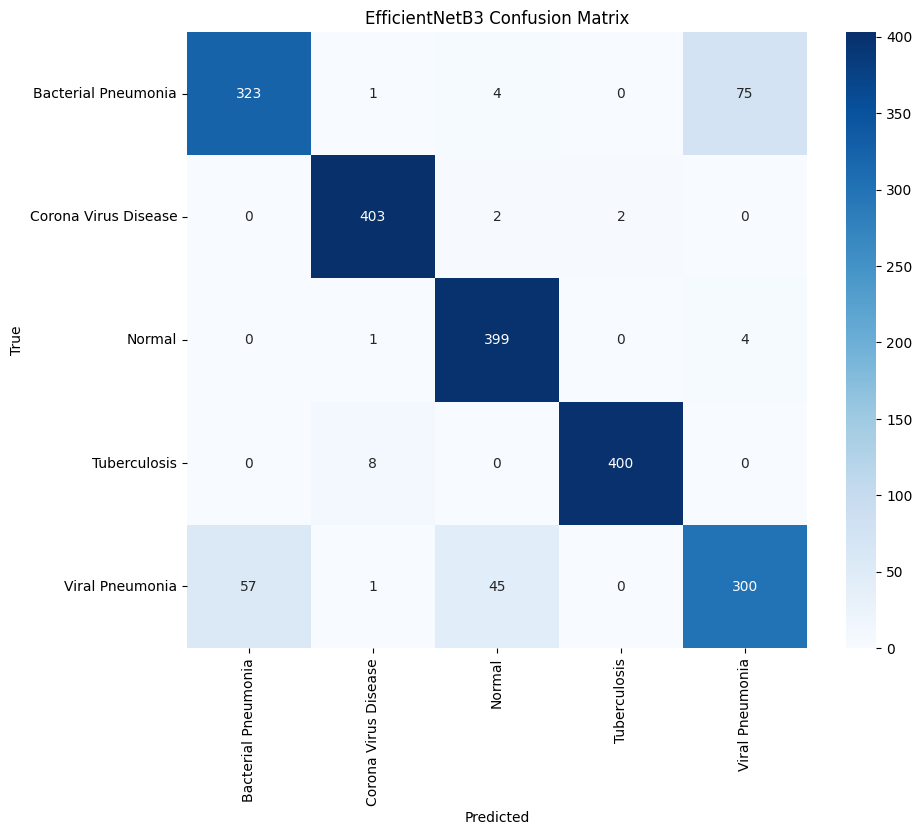

In [ ]:
# Classification Report and Confusion Matrix
print(classification_report(true_labels, y_pred_labels,target_names=class_names, digits=4))
conf_matrix = confusion_matrix(true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EfficientNetB3 Confusion Matrix')
plt.show()


In [ ]:
#  Per-class accuracy
def print_per_class_accuracy(conf_matrix, class_names):
    print("\n Per-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        true_positives = conf_matrix[i, i]
        total_samples = conf_matrix[i].sum()
        accuracy = (true_positives / total_samples) * 100
        print(f"- {class_name}: {accuracy:.2f}%")
class_names = list(test_generator.class_indices.keys())
print_per_class_accuracy(conf_matrix, class_names)



 Per-Class Accuracy:
- Bacterial Pneumonia: 80.15%
- Corona Virus Disease: 99.02%
- Normal: 98.76%
- Tuberculosis: 98.04%
- Viral Pneumonia: 74.44%


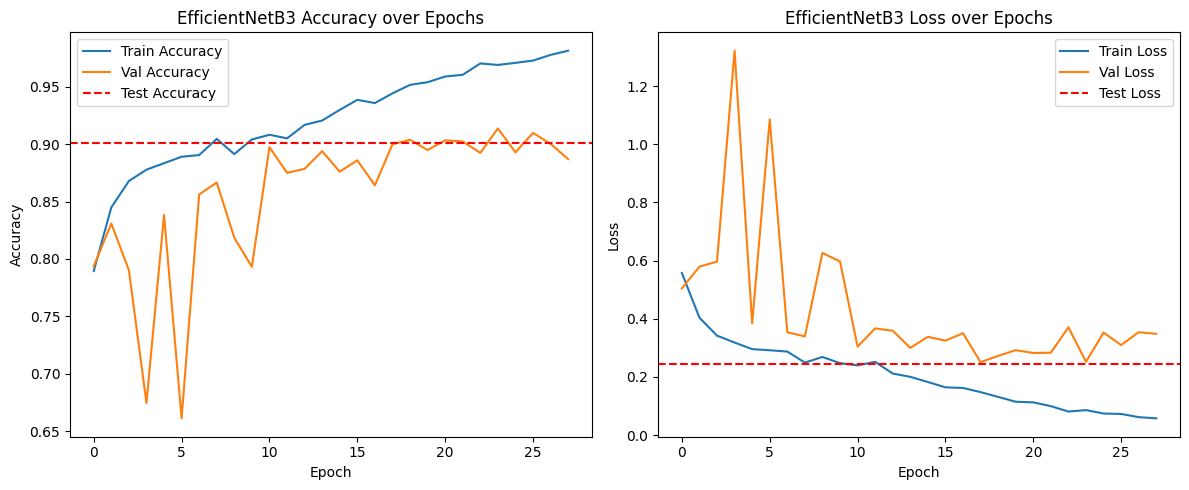

In [ ]:
#  Plot Accuracy and Loss (with Test)
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val Accuracy')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.title('EfficientNetB3 Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
plt.title('EfficientNetB3 Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

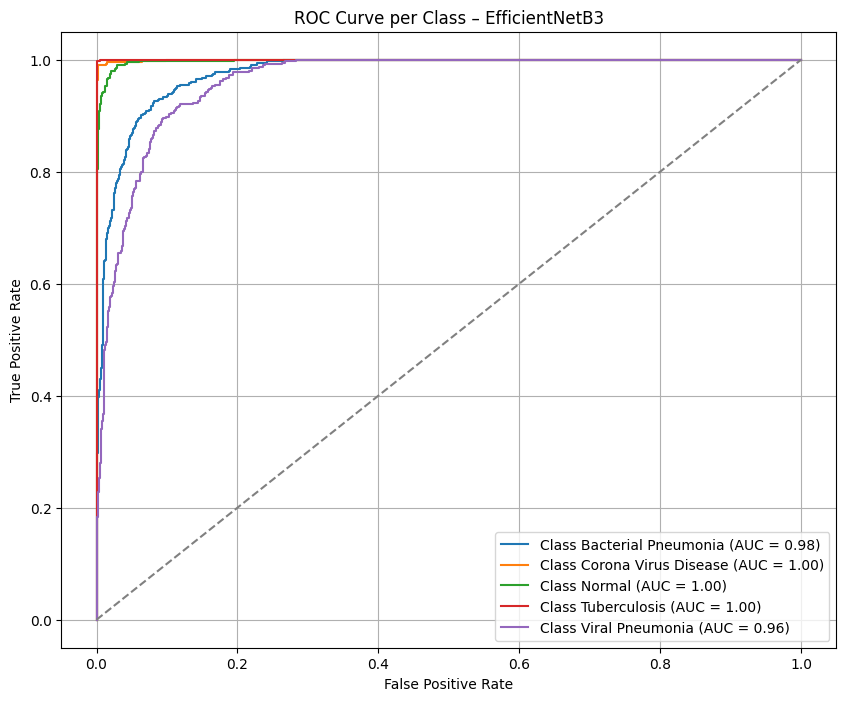

In [ ]:
#  ROC Curve for Each Class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(true_labels, classes=range(NUM_CLASSES))
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class – EfficientNetB3')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#  Show Model Architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        960 │ block1a_se_excit

 Total params: 33,360,272 (127.26 MB)

 Trainable params: 11,090,989 (42.31 MB)

 Non-trainable params: 87,303 (341.03 KB)

 Optimizer params: 22,181,980 (84.62 MB)